In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd # For playing audio in the notebook

# Set a nice style for plots
plt.style.use('seaborn-v0_8-whitegrid')
print(os.getcwd())

c:\Users\diaco\Desktop\Pachet-fisiere-IAECV-Proiect\notebooks


In [3]:
# --- Configuration ---
BASE_DIR = '../' # Assuming your notebook is in 'notebooks/' and data is one level up
AUDIO_DIR = os.path.join(BASE_DIR, 'data/extrAudio/')
ANNOTATION_DIR = os.path.join(BASE_DIR, 'data/datasetAnnotation/')

print(f"Audio directory: {AUDIO_DIR}")
print(f"Annotation directory: {ANNOTATION_DIR}")

Audio directory: ../data/extrAudio/
Annotation directory: ../data/datasetAnnotation/


In [4]:
def load_all_annotations(annotation_dir):
    all_annotations = []
    for csv_file in os.listdir(annotation_dir):
        if csv_file.endswith('.csv'):
            file_path = os.path.join(annotation_dir, csv_file)
            df = pd.read_csv(file_path)
            
            # --- FIX: Standardize 'Speaker' column to string type ---
            if 'Speaker' in df.columns:
                df['Speaker'] = df['Speaker'].astype(str) 
            else:
                print(f"Warning: 'Speaker' column not found in {csv_file}")
                continue # Skip files without Speaker column if necessary
            # --- End of FIX ---
            
            # Add filename and label (deceptive/sincere) to the dataframe
            df['audio_filename'] = csv_file.replace('.csv', '.wav')
            if 'trial_lie' in csv_file:
                df['label'] = 'deceptive'
            elif 'trial_truth' in csv_file:
                df['label'] = 'sincere'
            else:
                df['label'] = 'unknown' # Should not happen based on description
                print(f"Warning: Unknown label for file {csv_file}. Defaulting to 'unknown'.")
            all_annotations.append(df)
    
    if not all_annotations:
        print("No annotation files found or loaded. Check ANNOTATION_DIR.")
        return pd.DataFrame()
        
    return pd.concat(all_annotations, ignore_index=True)

raw_annotations_df = load_all_annotations(ANNOTATION_DIR)

if not raw_annotations_df.empty:
    print(f"--- Total utterances loaded (including TM): {len(raw_annotations_df)} ---")
    print(f"--- Original columns: {raw_annotations_df.columns.tolist()} ---")
    
    # ---  Filter out 'TM' Speakers from the Beginning ---
    # Ensure the column names 'Speaker', 'Start time', 'Stop time', 'Gender' are correct for your CSVs
    # (You confirmed these earlier: 'Start time', 'Stop time', 'Speaker', 'Gender')
    if 'Speaker' in raw_annotations_df.columns:
        annotations_df = raw_annotations_df[raw_annotations_df['Speaker'] != 'TM'].copy()
        # Using .copy() is good practice here to avoid SettingWithCopyWarning later
        print(f"--- Total utterances after filtering 'TM' speakers: {len(annotations_df)} ---")
    else:
        print("ERROR: 'Speaker' column not found in loaded annotations. Cannot filter 'TM'. Please check CSV headers.")
        annotations_df = raw_annotations_df # Proceed with unfiltered if 'Speaker' column is missing
else:
    annotations_df = pd.DataFrame() # Create an empty DataFrame if loading failed

--- Total utterances loaded (including TM): 1128 ---
--- Original columns: ['Start time', 'Stop time', 'Speaker', 'Gender', 'audio_filename', 'label'] ---
--- Total utterances after filtering 'TM' speakers: 929 ---


In [5]:
print("--- Columns in annotations_df ---")
print(annotations_df.columns.tolist()) 
# Or, to see the first few rows with column headers:
# print(annotations_df.head())

--- Columns in annotations_df ---
['Start time', 'Stop time', 'Speaker', 'Gender', 'audio_filename', 'label']


In [6]:
# --- Calculate Statistics (Now on the TM-filtered DataFrame) ---
if not annotations_df.empty:
    print("\n--- Statistics for SUBJECTS (TM speakers excluded) ---")

    # Number of unique audio files (recordings) for subjects
    num_subject_recordings = annotations_df['audio_filename'].nunique()
    print(f"Total number of unique audio recordings (subjects only): {num_subject_recordings}")

    subject_recordings_per_label = annotations_df.groupby('label')['audio_filename'].nunique()
    print(f"\nRecordings per label (subjects only):\n{subject_recordings_per_label}")

    # Total number of utterances for subjects
    total_subject_utterances = len(annotations_df)
    print(f"\nTotal number of utterances (subjects only): {total_subject_utterances}")

    # Utterances per label for subjects
    subject_utterances_per_label = annotations_df['label'].value_counts()
    print(f"\nUtterances per label (subjects only):\n{subject_utterances_per_label}")
    # Compare these counts to the documentation's 463 deceptive, 466 sincere.
    # Note: These numbers from the PDF might include 'TM' if 'TM' utterances were also labeled.
    # Your counts here will be strictly for non-'TM' speakers.

    # Number of unique subjects
    num_unique_subjects = annotations_df['Speaker'].nunique()
    print(f"\nTotal number of unique subjects: {num_unique_subjects}")
    # Expected from documentation: 56

    # Speaker gender distribution for subjects
    if 'Gender' in annotations_df.columns:
        subject_gender_distribution = annotations_df.drop_duplicates(subset=['Speaker'])['Gender'].value_counts()
        print(f"\nSubject gender distribution:\n{subject_gender_distribution}")
        # Expected from documentation: 22 Female, 34 Male
    else:
        print("\n'Gender' column not found. Cannot calculate gender distribution.")
else:
    print("Annotations DataFrame is empty or 'Speaker' column was missing. No statistics calculated.")



--- Statistics for SUBJECTS (TM speakers excluded) ---
Total number of unique audio recordings (subjects only): 120

Recordings per label (subjects only):
label
deceptive    60
sincere      60
Name: audio_filename, dtype: int64

Total number of utterances (subjects only): 929

Utterances per label (subjects only):
label
sincere      466
deceptive    463
Name: count, dtype: int64

Total number of unique subjects: 56

Subject gender distribution:
Gender
M    34
F    22
Name: count, dtype: int64


In [7]:
# Ensure annotations_df is the DataFrame AFTER filtering out 'TM'
# (Based on your notebook, cell [25] creates this)

if not annotations_df.empty and 'Speaker' in annotations_df.columns:
    unique_speakers = annotations_df['Speaker'].unique()
    num_unique_subjects = len(unique_speakers)
    
    print(f"Number of unique Speaker IDs found (excluding TM): {num_unique_subjects}") # Should print 63
    
    # Convert to a list and try sorting to make it easier to inspect.
    # Need to handle potential mix of numbers and strings for sorting.
    try:
        # Attempt to convert numeric-like strings to numbers for sorting
        speaker_list = sorted(list(unique_speakers), key=lambda x: int(x) if str(x).isdigit() else float('inf')) 
        # float('inf') puts non-numeric strings at the end
    except ValueError:
        # Fallback if conversion fails (e.g., unexpected non-numeric strings)
        print("Warning: Could not sort numerically due to non-numeric IDs. Sorting as strings.")
        speaker_list = sorted(list(unique_speakers))
        
    print("\nList of unique Speaker IDs found (excluding TM):")
    print(speaker_list)
    
else:
    print("annotations_df is empty or missing 'Speaker' column.")

Number of unique Speaker IDs found (excluding TM): 56

List of unique Speaker IDs found (excluding TM):
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56']


### trial_lie_051 is only TM so there is a total of 60 deceptive and 60 sincere audios



--- Exploring Sample Utterance ---
Audio file: trial_lie_001.wav
Start time: 0.37s
Stop time: 1.63s
Label: deceptive
Successfully loaded trial_lie_001.wav, Sample rate: 16000 Hz, Duration: 16.96s
Extracted utterance duration: 1.26s

Playing sample utterance:


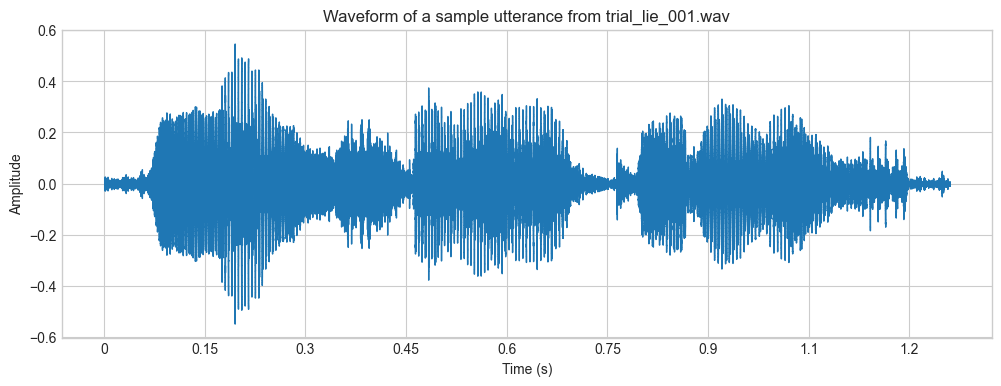

In [8]:
# Let's pick one utterance to explore
if not annotations_df.empty:
    sample_utterance = annotations_df.iloc[0]
    sample_audio_filename = sample_utterance['audio_filename']
    sample_audio_path = os.path.join(AUDIO_DIR, sample_audio_filename)

    print(f"\n--- Exploring Sample Utterance ---")
    print(f"Audio file: {sample_audio_filename}")
    print(f"Start time: {sample_utterance['Start time']}s")
    print(f"Stop time: {sample_utterance['Stop time']}s")
    print(f"Label: {sample_utterance['label']}")

    # Load the full audio file
    # The project states audio is 16kHz. librosa loads at 22050Hz by default.
    try:
        y_full, sr = librosa.load(sample_audio_path, sr=16000) # Load at 16kHz as specified
        print(f"Successfully loaded {sample_audio_filename}, Sample rate: {sr} Hz, Duration: {len(y_full)/sr:.2f}s")

        # Extract the specific utterance
        start_sample = librosa.time_to_samples(sample_utterance['Start time'], sr=sr)
        end_sample = librosa.time_to_samples(sample_utterance['Stop time'], sr=sr)
        y_utterance = y_full[start_sample:end_sample]
        
        utterance_duration = len(y_utterance) / sr
        print(f"Extracted utterance duration: {utterance_duration:.2f}s")

        # Play the utterance (optional, works in Jupyter)
        print("\nPlaying sample utterance:")
        ipd.display(ipd.Audio(y_utterance, rate=sr))

        # Visualize the waveform of the utterance
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(y_utterance, sr=sr)
        plt.title(f"Waveform of a sample utterance from {sample_audio_filename}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

    except Exception as e:
        print(f"Error loading or processing {sample_audio_path}: {e}")
else:
    print("Annotations DataFrame is empty. Skipping audio exploration.")


--- Utterance Duration Statistics ---
count    929.000000
mean       2.430205
std        1.853970
min        0.110000
25%        1.050000
50%        1.890000
75%        3.380000
max       11.900000
Name: utterance_duration_sec, dtype: float64


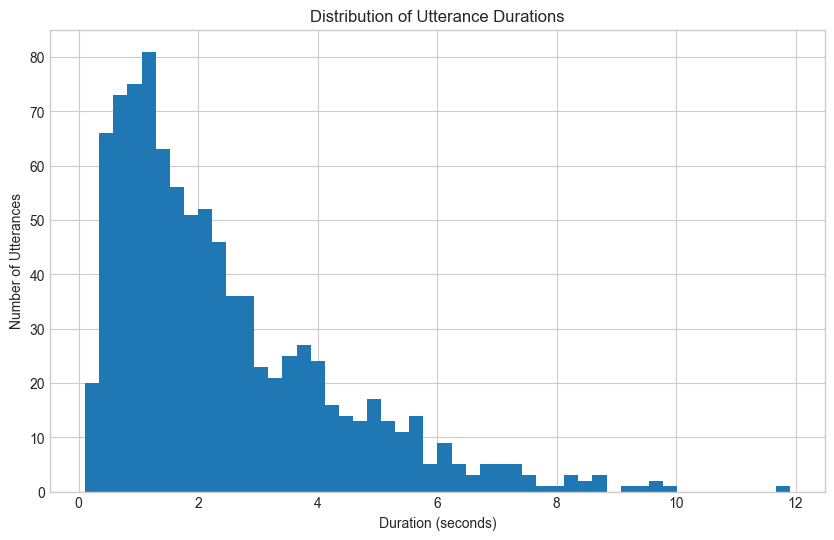

In [9]:
if not annotations_df.empty:
    annotations_df['utterance_duration_sec'] = annotations_df['Stop time'] - annotations_df['Start time']

    print("\n--- Utterance Duration Statistics ---")
    print(annotations_df['utterance_duration_sec'].describe())

    plt.figure(figsize=(10, 6))
    annotations_df['utterance_duration_sec'].hist(bins=50)
    plt.title("Distribution of Utterance Durations")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Number of Utterances")
    plt.show()
else:
    print("Annotations DataFrame is empty. Skipping utterance duration analysis.")

--- Exploring Sample Utterances from 929 available subject utterances ---

--- Sample #1 (Row index: 0) ---
Audio file: trial_lie_001.wav
Speaker: 1, Gender: F
Label: deceptive
Start time: 0.37s, End time: 1.63s
Calculated duration: 1.26s
Loaded full audio: trial_lie_001.wav, Sample rate: 16000 Hz
Extracted utterance duration from audio: 1.26s
Playing sample utterance:


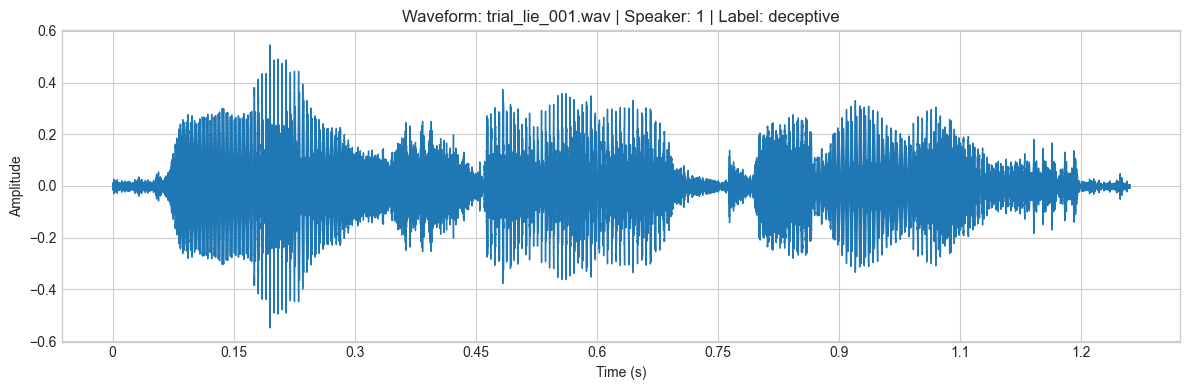


--- Sample #2 (Row index: 464) ---
Audio file: trial_truth_001.wav
Speaker: 21, Gender: F
Label: sincere
Start time: 3.68s, End time: 8.25s
Calculated duration: 4.57s
Loaded full audio: trial_truth_001.wav, Sample rate: 16000 Hz
Extracted utterance duration from audio: 4.57s
Playing sample utterance:


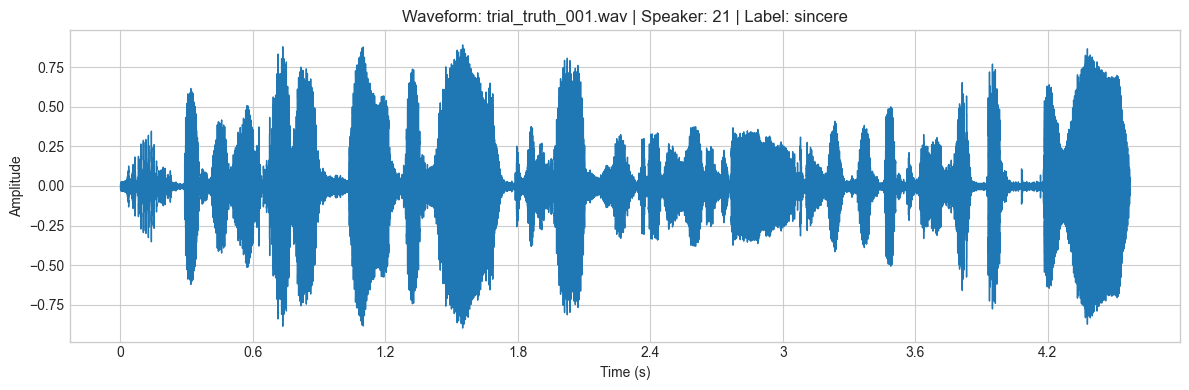


--- Sample #3 (Row index: 928) ---
Audio file: trial_truth_060.wav
Speaker: 9, Gender: F
Label: sincere
Start time: 18.21s, End time: 19.90s
Calculated duration: 1.69s
Loaded full audio: trial_truth_060.wav, Sample rate: 16000 Hz
Extracted utterance duration from audio: 1.69s
Playing sample utterance:


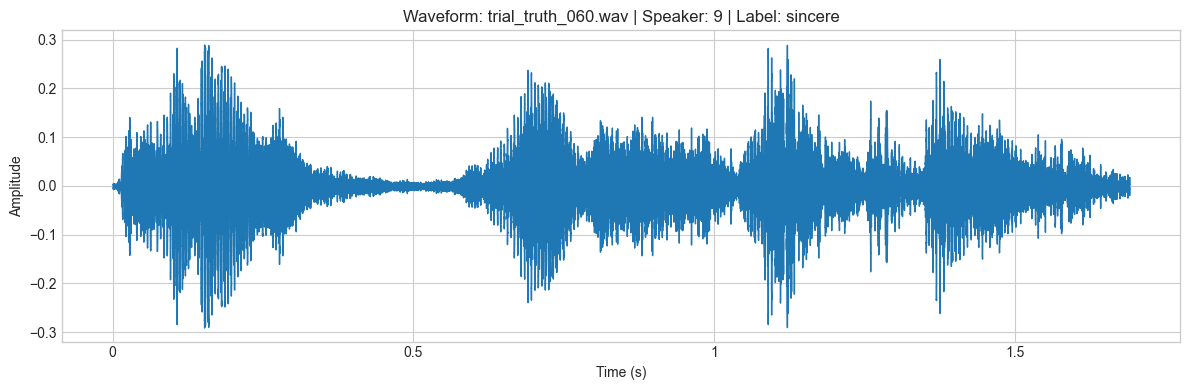

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd # For playing audio in the notebook

# Ensure your annotations_df is the one filtered for subjects (TM excluded)
# and has 'Start time', 'Stop time', 'audio_filename', 'label', 'Speaker', 'Gender' columns.

if not annotations_df.empty:
    print(f"--- Exploring Sample Utterances from {len(annotations_df)} available subject utterances ---")
    
    # Let's select a few samples, e.g., the first, one from the middle, and one towards the end
    # Or you can pick specific ones based on interesting stats you found (e.g., very short/long)
    sample_indices = [0, len(annotations_df) - 1] # First and last
    if len(annotations_df) > 100:
        sample_indices.append(len(annotations_df) // 2) # Middle one
    if len(annotations_df) > 1:
        sample_indices.append(len(annotations_df) - 1) # Last one
    
    # Make sure indices are unique and valid
    sample_indices = sorted(list(set(idx for idx in sample_indices if idx < len(annotations_df))))

    if not sample_indices:
        print("Not enough data to pick samples, or annotations_df is smaller than expected.")
    
    for i, sample_idx in enumerate(sample_indices):
        sample_utterance = annotations_df.iloc[sample_idx]
        sample_audio_filename = sample_utterance['audio_filename']
        # Correctly construct the full path to the audio file
        sample_audio_path = os.path.join(AUDIO_DIR, sample_audio_filename)

        print(f"\n--- Sample #{i+1} (Row index: {sample_idx}) ---")
        print(f"Audio file: {sample_audio_filename}")
        print(f"Speaker: {sample_utterance['Speaker']}, Gender: {sample_utterance['Gender']}")
        print(f"Label: {sample_utterance['label']}")
        print(f"Start time: {sample_utterance['Start time']:.2f}s, End time: {sample_utterance['Stop time']:.2f}s")
        if 'utterance_duration_sec' in sample_utterance:
             print(f"Calculated duration: {sample_utterance['utterance_duration_sec']:.2f}s")


        try:
            # Load the full audio file (project specifies 16kHz)
            y_full, sr = librosa.load(sample_audio_path, sr=16000)
            print(f"Loaded full audio: {sample_audio_filename}, Sample rate: {sr} Hz")

            # Extract the specific utterance using correct column names
            start_sample = librosa.time_to_samples(sample_utterance['Start time'], sr=sr)
            end_sample = librosa.time_to_samples(sample_utterance['Stop time'], sr=sr)
            y_utterance = y_full[start_sample:end_sample]
            
            actual_utterance_duration = len(y_utterance) / sr
            print(f"Extracted utterance duration from audio: {actual_utterance_duration:.2f}s")

            # Play the utterance
            print("Playing sample utterance:")
            ipd.display(ipd.Audio(y_utterance, rate=sr))

            # Visualize the waveform of the utterance
            plt.figure(figsize=(12, 4))
            librosa.display.waveshow(y_utterance, sr=sr)
            plt.title(f"Waveform: {sample_audio_filename} | Speaker: {sample_utterance['Speaker']} | Label: {sample_utterance['label']}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error loading or processing {sample_audio_path} for sample index {sample_idx}: {e}")
            # Common errors: FileNotFoundError if AUDIO_DIR is wrong or file is missing.
            # Issues with librosa if audio format is unexpected (though WAV should be fine).
else:
    print("annotations_df is empty. Cannot explore sample utterances.")


--- Visualizing Sample Spectrograms from 929 available subject utterances ---

--- Spectrogram for Sample #1 (Row index: 0) ---
Audio file: trial_lie_001.wav, Speaker: 1, Label: deceptive
Start time: 0.37s, End time: 1.63s


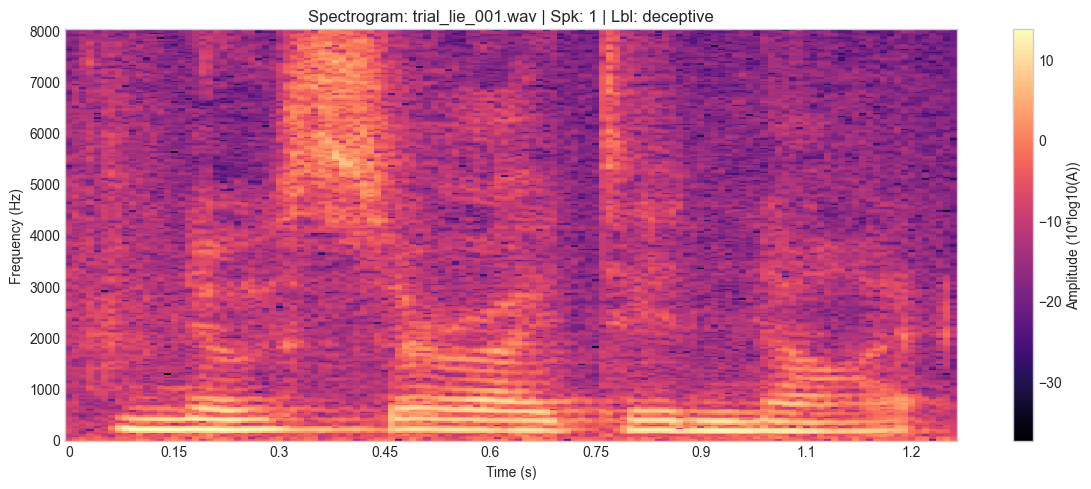


--- Spectrogram for Sample #2 (Row index: 464) ---
Audio file: trial_truth_001.wav, Speaker: 21, Label: sincere
Start time: 3.68s, End time: 8.25s


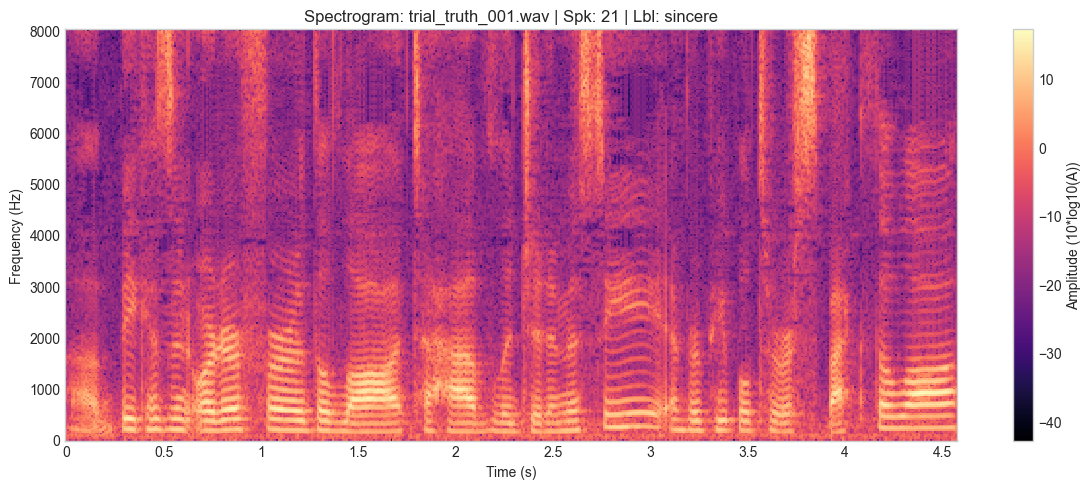


--- Spectrogram for Sample #3 (Row index: 928) ---
Audio file: trial_truth_060.wav, Speaker: 9, Label: sincere
Start time: 18.21s, End time: 19.90s


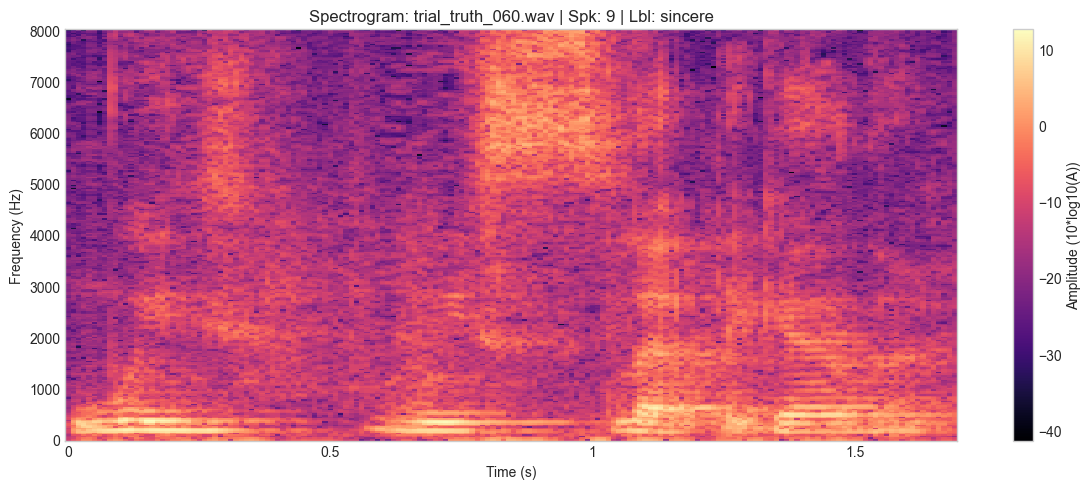

In [ ]:
# Spectrogram Parameters from PDF
TARGET_SR_SPECTRO = 16000
FRAME_LENGTH_MS_SPECTRO = 25
FRAME_HOP_MS_SPECTRO = 10
N_FFT_SPECTRO = 512
NUM_FREQ_BINS_SPECTRO = 257 # Corresponds to 0-8kHz for SR=16kHz and N_FFT=512

def get_spectrogram_for_notebook(utterance_audio, sr, 
                                 frame_length_ms, frame_hop_ms, 
                                 n_fft, num_freq_bins):
    """
    Extracts and processes a spectrogram for a single utterance for visualization.
    Does not pad to max dataset length, just processes the given utterance.
    """
    if utterance_audio is None or len(utterance_audio) == 0:
        print("Cannot generate spectrogram for empty audio.")
        return None

    frame_length_samples = int(sr * frame_length_ms / 1000)
    hop_length_samples = int(sr * frame_hop_ms / 1000)

    if frame_length_samples == 0 or hop_length_samples == 0:
        print("Frame or hop length is zero. Cannot generate spectrogram.")
        return None

    try:
        # STFT
        D_stft = librosa.stft(utterance_audio, 
                              n_fft=n_fft, 
                              hop_length=hop_length_samples, 
                              win_length=frame_length_samples,
                              window='hamm') # Hamming window as recommended
        
        # Magnitude and select frequency bins
        S_mag = np.abs(D_stft)
        S_mag_selected_bins = S_mag[:num_freq_bins, :] # Keep first 257 bins

        # Log amplitude scaling (10 * log10(amplitude))
        epsilon = 1e-10 # To avoid log(0)
        S_log_amplitude = 10 * np.log10(S_mag_selected_bins + epsilon)
        # Note: The PDF says "logaritm în baza 10, apoi înmulţire cu 10, unitatea de măsură fiind [dB]"
        # This is what's implemented above. librosa.amplitude_to_db uses 20*log10(S/ref).
        
        return S_log_amplitude
    except Exception as e:
        print(f"Error during spectrogram extraction: {e}")
        return None

# Ensure annotations_df (filtered) and AUDIO_DIR are available from previous cells
if 'annotations_df' in locals() and not annotations_df.empty:
    print(f"\n--- Visualizing Sample Spectrograms from {len(annotations_df)} available subject utterances ---")
    
    # Use the same sample indices as for waveform visualization, or pick new ones
    # These were defined in cell [42] in your notebook as:
    # sample_indices = [0, len(annotations_df) // 2, len(annotations_df) - 1]
    # Re-create or ensure it's valid:
    sample_indices_spectro = [0] 
    if len(annotations_df) > 100:
        sample_indices_spectro.append(len(annotations_df) // 2)
    if len(annotations_df) > 1:
         # Ensure we don't add the same index twice if len is small
        if (len(annotations_df) -1) not in sample_indices_spectro:
            sample_indices_spectro.append(len(annotations_df) - 1)
    
    sample_indices_spectro = sorted(list(set(idx for idx in sample_indices_spectro if idx < len(annotations_df))))


    if not sample_indices_spectro:
        print("Not enough data to pick samples for spectrograms.")
    
    for i, sample_idx in enumerate(sample_indices_spectro):
        sample_utterance_info = annotations_df.iloc[sample_idx]
        sample_audio_filename = sample_utterance_info['audio_filename']
        sample_audio_path = os.path.join(AUDIO_DIR, sample_audio_filename)

        print(f"\n--- Spectrogram for Sample #{i+1} (Row index: {sample_idx}) ---")
        print(f"Audio file: {sample_audio_filename}, Speaker: {sample_utterance_info['Speaker']}, Label: {sample_utterance_info['label']}")
        print(f"Start time: {sample_utterance_info['Start time']:.2f}s, End time: {sample_utterance_info['Stop time']:.2f}s")

        try:
            # Load the specific utterance audio (using your utils.load_utterance if available and preferred)
            # For simplicity here, reloading segment directly:
            y_full_spectro, sr_spectro_orig = librosa.load(sample_audio_path, sr=None)
            
            # Resample if necessary
            if sr_spectro_orig != TARGET_SR_SPECTRO:
                y_full_spectro = librosa.resample(y_full_spectro, orig_sr=sr_spectro_orig, target_sr=TARGET_SR_SPECTRO)
            
            sr_spectro = TARGET_SR_SPECTRO

            start_sample_s = librosa.time_to_samples(sample_utterance_info['Start time'], sr=sr_spectro)
            end_sample_s = librosa.time_to_samples(sample_utterance_info['Stop time'], sr=sr_spectro)
            y_utterance_spectro = y_full_spectro[start_sample_s:end_sample_s]
            
            if len(y_utterance_spectro) == 0:
                print("Utterance audio is empty, skipping spectrogram.")
                continue

            # Extract spectrogram
            spectrogram = get_spectrogram_for_notebook(y_utterance_spectro, sr_spectro,
                                                       FRAME_LENGTH_MS_SPECTRO, FRAME_HOP_MS_SPECTRO,
                                                       N_FFT_SPECTRO, NUM_FREQ_BINS_SPECTRO)
            if spectrogram is not None:
                plt.figure(figsize=(12, 5))
                librosa.display.specshow(spectrogram, 
                                         sr=sr_spectro, 
                                         hop_length=int(sr_spectro * FRAME_HOP_MS_SPECTRO / 1000), 
                                         x_axis='time', 
                                         y_axis='linear', # PDF specifies linear frequency scale
                                         cmap='magma') # Or 'viridis', 'plasma'
                plt.colorbar(label='Amplitude (10*log10(A))') # Label according to your scaling
                plt.title(f"Spectrogram: {sample_audio_filename} | Spk: {sample_utterance_info['Speaker']} | Lbl: {sample_utterance_info['label']}")
                plt.xlabel("Time (s)")
                plt.ylabel("Frequency (Hz)")
                plt.tight_layout()
                plt.show()
            else:
                print("Spectrogram could not be generated.")

        except Exception as e:
            print(f"Error loading/processing audio for spectrogram (index {sample_idx}): {e}")
else:
    print("annotations_df is not defined or is empty. Please run previous cells.")